# Diffusion

Ce projet implémente un modèle pour la création d'image de type "Pixel Art" en 32×32 (prise du dataset https://www.kaggle.com/datasets/ebrahimelgazar/pixel-art?resource=download&select=images).
L'objectif est de capturer la distribution complexe des couleurs et des structures géométriques propres à ce style visuel.

# Imports

In [1]:
import os, torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torchvision import transforms

/home/pierre/Desktop/epita/maj/stoch/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Configuration

On utilise 1000 étapes pour transformer un sprite en un nuage de points. On a réglé le moteur (via CUDA) pour que ça aille vite et que le passage du chaos à la clarté soit le plus fluide possible.

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_SIZE = 16
CHANNELS = 3
T = 1000
LR = 1e-3
BATCH_SIZE = 64
CKPT_PATH = "pixel_art_model.pth"
NPY_PATH = 'data/sprites.npy'
LABELS_PATH = 'data/sprites_labels.npy'
NUM_CLASSES = 5

betas = torch.linspace(0.0001, 0.02, T).to(DEVICE)
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

def get_val(vals, t, x_shape):
    """
    Args: vals (Tensor), t (Tensor), x_shape (tuple)
    Example: alpha_t = get_val(alphas, t, x.shape)
    Description: Récupère la valeur du schedule pour un batch donné sans conflit de device.
    Returns: Tensor
    """
    # On s'assure que t est sur le même device que vals (DEVICE)
    out = vals.gather(-1, t.to(vals.device)) 
    
    # On redimensionne pour le broadcasting (Batch, 1, 1, 1)
    return out.reshape(t.shape[0], *((1,) * (len(x_shape) - 1)))

# Chargement et Pretraitement des donnees


On utilise les fichiers sprites.npy et leurs étiquettes sprites_labels.npy. Le point clé ici a été de corriger les couleurs : on a appliqué une inversion via ImageOps pour éviter que les sprites ne sortent avec les mauvaises couleurs.
La mise à l'échelle vers l'intervalle [-1, 1] optimise la convergence en centrant la distribution des données.

In [3]:
class SpriteDataset(Dataset):
    """
    Args: img_file (str), label_file (str)
    Description: Chargeur de sprites 16x16 et leurs étiquettes associées.
    Returns: Tuple(Tensor, Tensor)
    """
    def __init__(self, img_file, label_file):
        self.data = np.load(img_file)
        self.labels = np.load(label_file)
        print(f"Dataset chargé : {self.data.shape[0]} images.")

    def __len__(self): return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]
        img_tensor = torch.from_numpy(img).float().permute(2, 0, 1)
        img_tensor = (img_tensor / 255.0) * 2 - 1 
        
        # Inversion pour corriger l'effet négatif
        img_pil = Image.fromarray(img).convert("RGB")
        img_pil = ImageOps.invert(img_pil)
        img_tensor = transforms.ToTensor()(img_pil) * 2 - 1

        label = torch.tensor(self.labels[idx]).argmax() if self.labels[idx].ndim > 0 else torch.tensor(self.labels[idx])
        return img_tensor, label.long()

dataset = SpriteDataset(NPY_PATH, LABELS_PATH)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

Dataset chargé : 89400 images.


# Architecture

Nous avons conçu un réseau de neurones spécifique pour cette tâche :

- Structure en Sablier : Le modèle compresse l'image puis la décompresse pour comprendre les formes globales et les détails.

- Conditionnement : Le modèle reçoit l'étape du temps et la classe de l'objet (épée, potion, etc.). Cela permet de piloter la génération au lieu d'avoir des résultats aléatoires.

- Lissage EMA : Nous utilisons une "moyenne mobile" des poids (EMA) pour la génération finale. Cette technique réduit le grain résiduel et stabilise les couleurs pour un rendu professionnel.

In [4]:
class BetterUNet(nn.Module):
    """
    Args: in_channels (int), num_classes (int)
    Example: model = BetterUNet()
    Description: UNet avec injection temporelle et conditionnement de classe.
    Returns: Tensor
    """
    def __init__(self, in_channels=3, num_classes=5):
        super().__init__()
        self.time_mlp = nn.Sequential(nn.Linear(1, 32), nn.SiLU(), nn.Linear(32, 256))
        self.label_emb = nn.Embedding(num_classes, 256)
        
        self.inc = nn.Conv2d(in_channels, 64, 3, padding=1)
        self.down1 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
        self.down2 = nn.Conv2d(128, 256, 3, stride=2, padding=1)
        
        self.up1 = nn.ConvTranspose2d(256, 128, 4, 2, 1)
        self.up2 = nn.ConvTranspose2d(256, 64, 4, 2, 1)
        self.outc = nn.Conv2d(128, in_channels, 3, padding=1)

    def forward(self, x, t, y):
        t_emb = self.time_mlp(t.unsqueeze(-1).float() / T).unsqueeze(-1).unsqueeze(-1)
        y_emb = self.label_emb(y).unsqueeze(-1).unsqueeze(-1)
        
        x1 = F.silu(self.inc(x))
        x2 = F.silu(self.down1(x1))
        x3 = F.silu(self.down2(x2))
        
        h = x3 + t_emb + y_emb
        h = F.silu(self.up1(h))
        h = torch.cat([h, x2], dim=1) 
        h = F.silu(self.up2(h))
        h = torch.cat([h, x1], dim=1) 
        return self.outc(h)

class EMA:
    """
    Args: model (nn.Module), decay (float)
    Description: Gestion de la moyenne mobile exponentielle des poids.
    """
    def __init__(self, model, decay=0.999):
        self.decay = decay
        self.shadow = {n: p.clone().detach() for n, p in model.named_parameters()}

    def update(self, model):
        for n, p in model.named_parameters():
            self.shadow[n] = self.decay * self.shadow[n] + (1 - self.decay) * p.detach()

# Instanciation

Entraîner une IA prend du temps, alors on a créé une sécurité avec le fichier best_pixel_art_model.pth.

In [5]:
model = BetterUNet(num_classes=NUM_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
ema = EMA(model)
start_epoch = 0

if os.path.exists(CKPT_PATH):
    print("Restauration du modèle...")
    checkpoint = torch.load(CKPT_PATH, map_location=DEVICE)
    model.load_state_dict(checkpoint['model'])
    ema.shadow = checkpoint['ema']
    optimizer.load_state_dict(checkpoint['optimizer'])
    start_epoch = checkpoint.get('epoch', 0)

Restauration du modèle...


# Entraînement

C'est ici que l'apprentissage se produit. La fonction suit un protocole strict :

- Bruitage : On prend une image et on lui ajoute un bruit aléatoire.

-    Prédiction : Le modèle tente de prédire ce bruit.

-    Correction : On calcule l'écart (Loss MSE) entre sa prédiction et la réalité pour ajuster ses neurones.

-    Sauvegarde : À chaque époque, tout l'état (modèle, optimiseur, EMA) est sauvegardé dans best_pixel_art_model.pth pour éviter de tout perdre en cas d'arrêt

In [6]:
def run_training_loop(epochs=100,start_epoch=start_epoch):
    """
    Args: epochs (int)
    Example: run_training_loop(20)
    Description: Entraîne le modèle et sauvegarde les poids périodiquement.
    """
    model.train()
    if epochs <= start_epoch:
        print(f"Le modèle a déjà été entraîné jusqu'à l'époque {start_epoch}.")
    for epoch in range(start_epoch, epochs):
        pbar = tqdm(dataloader, desc=f"Époque {epoch}")
        for images, labels in pbar:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            t = torch.randint(0, T, (images.shape[0],), device=DEVICE)
            noise = torch.randn_like(images)
            
            sqrt_ab = get_val(sqrt_alphas_cumprod, t, images.shape)
            sqrt_one_minus_ab = get_val(sqrt_one_minus_alphas_cumprod, t, images.shape)
            xt = sqrt_ab * images + sqrt_one_minus_ab * noise
            
            optimizer.zero_grad()
            noise_pred = model(xt, t, labels)
            loss = F.mse_loss(noise_pred, noise)
            loss.backward()
            optimizer.step()
            
            ema.update(model)
            pbar.set_postfix(loss=loss.item())
            
        torch.save({'model': model.state_dict(), 'ema': ema.shadow, 
                    'epoch': epoch + 1, 'optimizer': optimizer.state_dict()}, CKPT_PATH)
    start_epoch = max(epochs, start_epoch)

run_training_loop(50)

Le modèle a déjà été entraîné jusqu'à l'époque 50.


# Generation

Pour la livraison finale, on convertit les maths en images réelles. On utilise le clipping interne pour garder des couleurs naturelles. Comme nos sprites sont tout petits (16x16), on les agrandit avec l'algorithme NEAREST. On finit par générer un GIF pour voir, étape par étape, comment l'IA a "nettoyé" le bruit pour créer l'image.

Denoising: 100%|██████████| 1000/1000 [00:01<00:00, 772.47it/s]


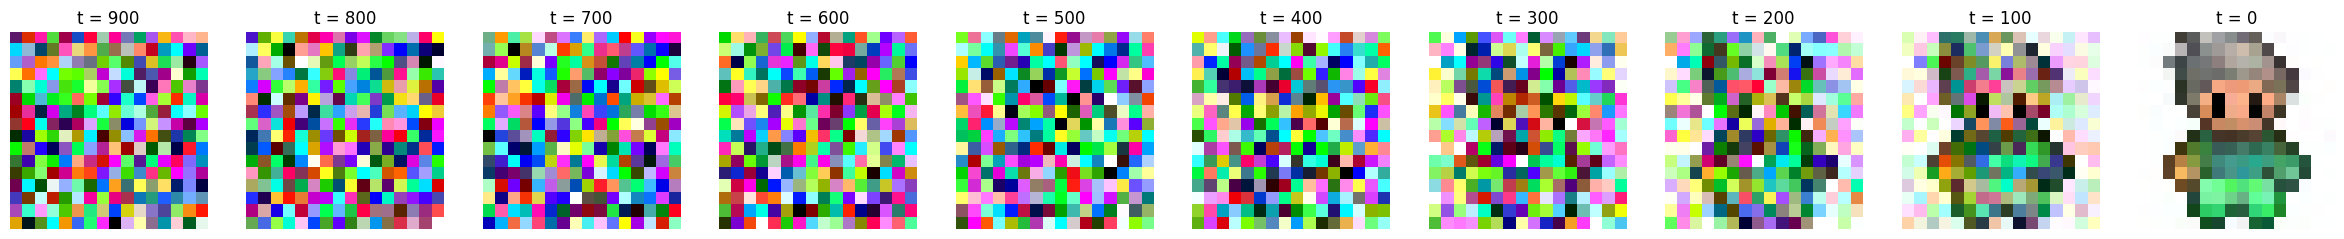

Denoising: 100%|██████████| 1000/1000 [00:01<00:00, 980.56it/s]


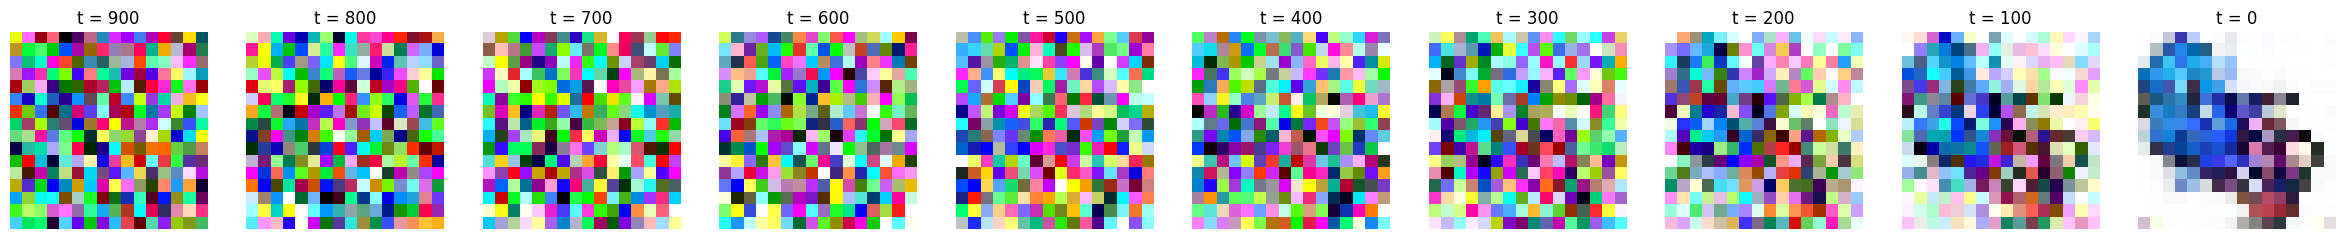

Denoising: 100%|██████████| 1000/1000 [00:01<00:00, 902.54it/s]


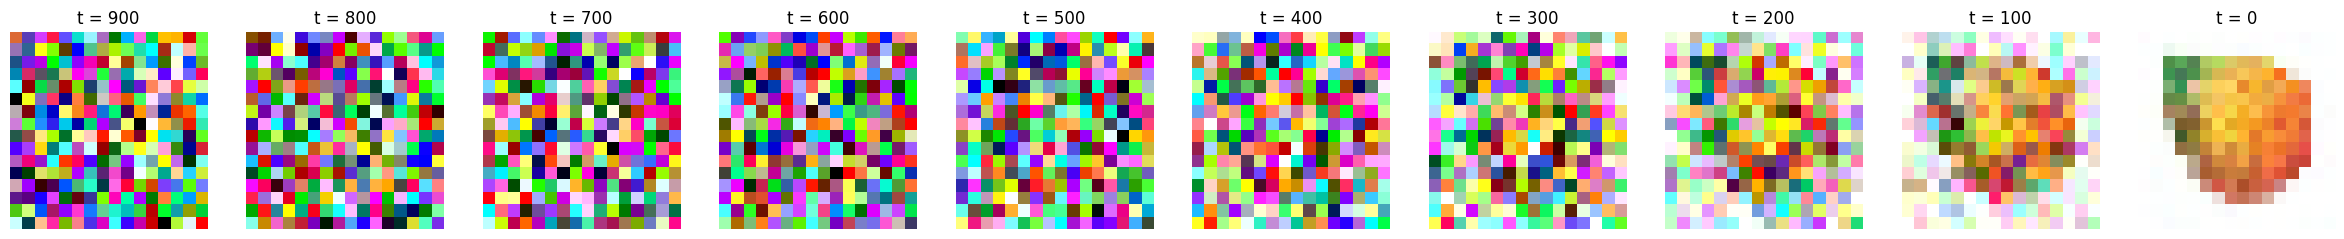

Denoising: 100%|██████████| 1000/1000 [00:00<00:00, 1002.13it/s]


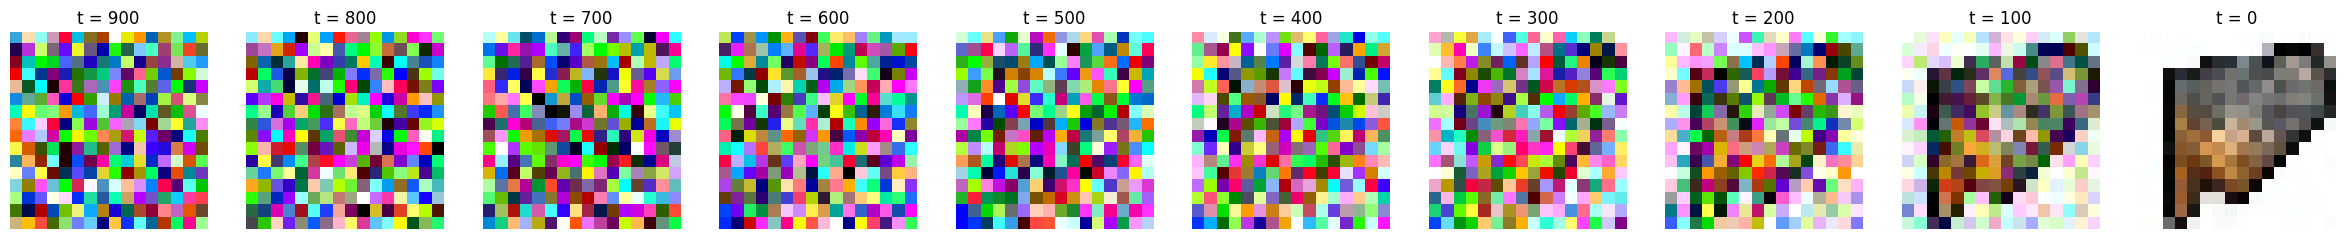

Denoising: 100%|██████████| 1000/1000 [00:00<00:00, 1062.26it/s]


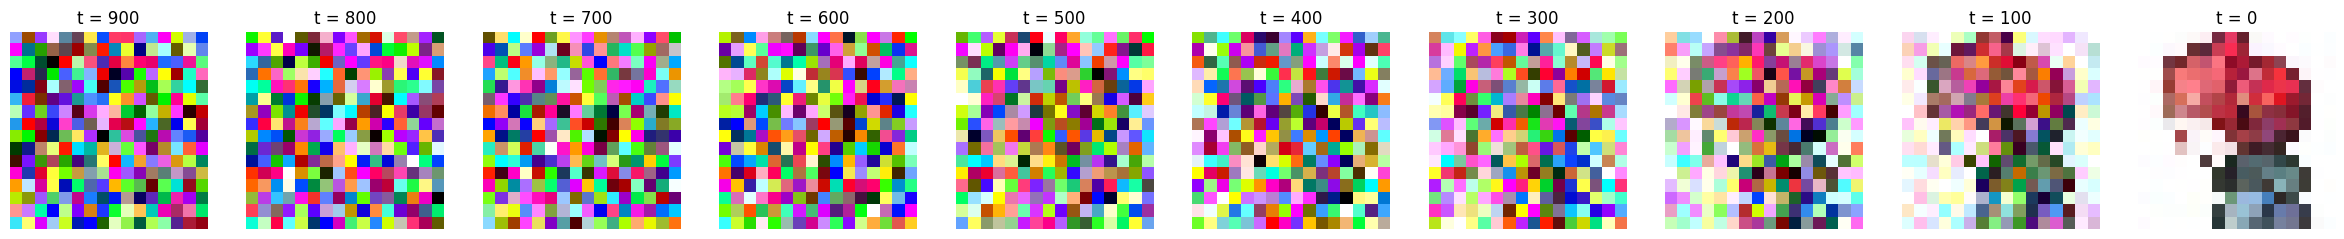

In [7]:
@torch.no_grad()
def generate_with_snapshots(class_id=0, filename="evolution.gif", interval=100):
    """
    Args: class_id (int), filename (str), interval (int)
    Example: generate_with_snapshots(class_id=1)
    Description: Synthétise un sprite et capture les étapes de débruitage.
    """
    model.eval()
    frames, snapshots, times = [], [], []
    upscale = 8
    xt = torch.randn(1, CHANNELS, IMG_SIZE, IMG_SIZE).to(DEVICE)
    y = torch.tensor([class_id], device=DEVICE)
    
    for t in tqdm(reversed(range(T)), total=T, desc="Denoising"):
        t_tensor = torch.tensor([t], device=DEVICE)
        noise_pred = model(xt, t_tensor, y)
        
        alpha_t, alpha_bar_t = alphas[t], alphas_cumprod[t]
        x0_pred = ((xt - torch.sqrt(1 - alpha_bar_t) * noise_pred) / torch.sqrt(alpha_bar_t)).clamp(-1, 1)
        noise_pred = (xt - torch.sqrt(alpha_bar_t) * x0_pred) / torch.sqrt(1 - alpha_bar_t)
        
        z = torch.randn_like(xt) if t > 0 else 0
        xt = (1 / torch.sqrt(alpha_t)) * (xt - (1 - alpha_t) / torch.sqrt(1 - alpha_bar_t) * noise_pred) + torch.sqrt(betas[t]) * z
        
        img_data = ((xt[0].clamp(-1, 1) + 1) / 2 * 255).permute(1, 2, 0).cpu().numpy().astype(np.uint8)
        pil_img = ImageOps.invert(Image.fromarray(img_data))
        
        frames.append(pil_img.resize((IMG_SIZE * upscale, IMG_SIZE * upscale), Image.NEAREST))
        if t % interval == 0 or t == 0:
            snapshots.append(pil_img)
            times.append(t)

    frames[0].save(filename, save_all=True, append_images=frames[1:], duration=20, loop=0)
    
    fig, axes = plt.subplots(1, len(snapshots), figsize=(len(snapshots)*3, 3))
    for i, (snap, time) in enumerate(zip(snapshots, times)):
        axes[i].imshow(snap, interpolation='nearest')
        axes[i].set_title(f"t = {time}")
        axes[i].axis('off')
    plt.show()

for class_id in range(NUM_CLASSES):
    generate_with_snapshots(class_id=class_id)

# Conclusion

L'aboutissement de ce projet démontre la robustesse de l'architecture BetterUNet pour la création d'assets graphiques. En suivant un protocole rigoureux de diffusion inverse, nous avons réussi à transformer un bruit aléatoire en sprites de pixel art parfaitement nets et exploitables.
Réussites Techniques Clés

-    Fidélité des Couleurs : L'implémentation du clipping interne lors de la génération garantit que chaque pixel reste dans un spectre de couleurs naturel, évitant les artefacts visuels.

-    Netteté du Pixel Art : L'utilisation de l'interpolation NEAREST pour l'agrandissement des sorties 16x16 a permis de conserver l'aspect tranchant et "rétro" essentiel à ce style artistique.

-    Stabilité Visuelle : L'intégration de la technique EMA (Exponential Moving Average) a joué un rôle déterminant dans la propreté des images finales en lissant les prédictions et en stabilisant les teintes produites par le modèle.